In [1]:
import sys
sys.path.append("../src")

from utils.load_model import get_model

from my_model import get_ilsvrc2012

from torch.utils.data import DataLoader

from utils.imagenet1000_classname import imgnet_label_name
from utils.tensortracker import TensorTracker
from utils.tensortracker import TensorTrackerInputGrad
from utils import plots

In [2]:
%matplotlib inline

In [3]:
import os
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch.nn as nn

import svcca

In [4]:
from my_model import my_resnet

from glob import glob

from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [5]:
from utils.receptive_field_tracker import RFTracker

from collections import OrderedDict

In [6]:
mode = "test"
test_dataset = get_ilsvrc2012(mode=mode, transform_type="test")
test_labels = np.asarray(test_dataset.targets)

index = []
for i in range(1000):
    idx = np.where(test_labels == i)[0][0]
    index.append(idx)
index = np.asarray(index)

device = "cpu"
N = 10
np.random.seed(815)
perm = np.random.permutation(len(index))
images = [test_dataset[i][0] for i in index[perm[:N]]]
images = torch.stack(images)
images = images.to(device)

In [7]:
from utils.analysis import make_dir
from utils.analysis import analyis_layers

In [8]:
model = get_model("resnet34-skip4")
model = model.eval()
model = model.to(device)

In [9]:
rf_tracker = RFTracker(model)

In [10]:
_ = model(images)

In [11]:
rf_sizes = {}
act_name = "relu2"
for cand_layer in analyis_layers:
    try:
        rf_sizes[cand_layer] = rf_tracker.rf_pool[cand_layer][2]
    except KeyError:
        key = "{}.{}".format(cand_layer, act_name)
        rf_sizes[cand_layer] = rf_tracker.rf_pool[key][2]

In [12]:
rf_tracker.remove_hook()

In [13]:
tracker = TensorTracker(model, candidate_layers=analyis_layers)
_ = model(images)

In [14]:
tracker.find_fmap("maxpool").shape

torch.Size([10, 64, 56, 56])

In [15]:
channels = {}
for cand_layer in analyis_layers:
    try:
        channels[cand_layer] = tracker.fmap_pool[cand_layer].shape[1]
    except KeyError:
        key = "{}.{}".format(cand_layer, act_name)
        channels[cand_layer] = tracker.fmap_pool[key].shape[1]

In [16]:
channels

{'maxpool': 64,
 'layer1.0': 64,
 'layer1.1': 64,
 'layer1.2': 64,
 'layer2.0': 128,
 'layer2.1': 128,
 'layer2.2': 128,
 'layer2.3': 128,
 'layer3.0': 256,
 'layer3.1': 256,
 'layer3.2': 256,
 'layer3.3': 256,
 'layer3.4': 256,
 'layer3.5': 256,
 'layer4.0': 512,
 'layer4.1': 512,
 'layer4.2': 512}

In [17]:
tracker.remove_hook()

In [18]:
in_dir = "20201228/resnet/"

In [19]:
in_path = os.path.join(in_dir, "data.pkl")

In [20]:
with open(in_path, "rb") as f:
    data = pickle.load(f)

In [21]:
data["g_plots_layers_power"][0].shape

(3, 11)

In [22]:
archs = [
    "resnet34-skip4",
    "resnet34-plain4",
]

In [23]:
arch = archs[0]
model = get_model(arch)
model = model.eval()
model = model.to(device)

tracker = TensorTrackerInputGrad(model, ignore_BN=True, detach_tensors=True)

_ = model(images)

In [24]:
out_dir = "20210118/{}".format(arch)
make_dir(out_dir)

exts = ("png", "pdf")

plt.rcParams["font.size"] = 24

In [42]:
g_imgs_layers = []
M = 10
for cnt, layer_name in enumerate(analyis_layers):
    torch.manual_seed(815)
    channel = channels[layer_name]
    g_imgs = []
    for j in tqdm(range(channel)):
        tmp_images = torch.randn(M, 3, 224, 224).to(device)
        tmp_images = tmp_images.requires_grad_()

        model.zero_grad()
        
        out = model.layer_forward(tmp_images, layers=[layer_name])[layer_name]
        
        g_y = torch.zeros(*out.shape)
        g_y[:, j, out.shape[-2] // 2, out.shape[-1] // 2] = 1
    #     g_y = torch.ones(out[:, j, 7 // 2, 7 // 2].shape)
        g_y = g_y.to(device)
    #     out[:, j, 7 // 2, 7 // 2].backward(gradient=g_y)
        out.backward(gradient=g_y)
        g_img = tracker.grad_pool_in["conv1"].detach().numpy()
        g_imgs.append(g_img)

    g_imgs = np.concatenate(g_imgs, axis=0)
    g_imgs_layers.append(g_imgs)

100%|██████████| 512/512 [04:06<00:00,  2.08it/s]


In [45]:
g_imgs_layers[0].shape

(640, 3, 224, 224)

In [55]:
erfs = []
for cnt, layer_name in enumerate(analyis_layers):
    center_pos = 224 / 2
    rf_size = rf_sizes[layer_name]
    rf_size = 224 if rf_size > 224 else rf_size
    x1 = int(np.ceil(center_pos - rf_size / 2))
    x2 = int(np.ceil(center_pos + rf_size / 2))
    y1 = int(np.ceil(center_pos - rf_size / 2))
    y2 = int(np.ceil(center_pos + rf_size / 2))
    print(layer_name, x1, x2, y1, y2)
    erf = np.abs(g_imgs_layers[cnt][:, :, x1:x2, y1:y2]).mean(0)
    erfs.append(erf)


maxpool 107 118 107 118
layer1.0 99 126 99 126
layer1.1 91 134 91 134
layer1.2 83 142 83 142
layer2.0 71 154 71 154
layer2.1 55 170 55 170
layer2.2 39 186 39 186
layer2.3 23 202 23 202
layer3.0 0 224 0 224
layer3.1 0 224 0 224
layer3.2 0 224 0 224
layer3.3 0 224 0 224
layer3.4 0 224 0 224
layer3.5 0 224 0 224
layer4.0 0 224 0 224
layer4.1 0 224 0 224
layer4.2 0 224 0 224


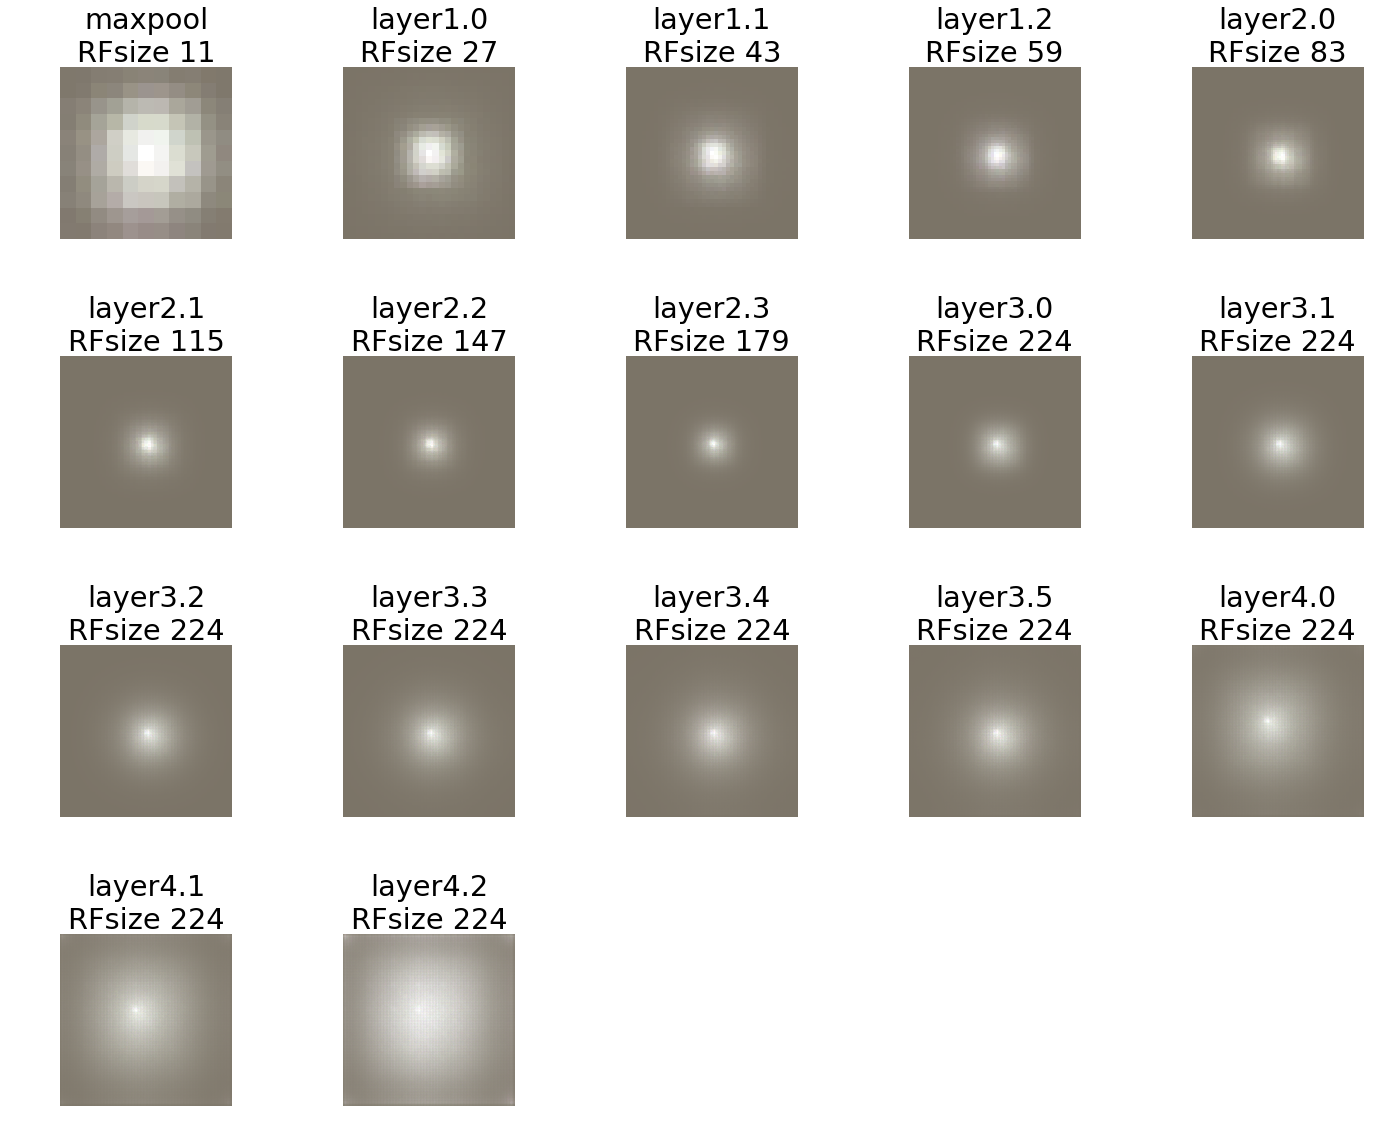

In [66]:
def _normalize(_x):
    _x = plots.normalize_inputspace(_x, img_format="HWC")
    _x = plots.input2image(_x, img_format="HWC")
    return _x

def _title(i, img):
    layer_name = analyis_layers[i]
    rfsize = rf_sizes[layer_name]
    rfsize = 224 if rfsize > 224 else rfsize
    msg = "{}\nRFsize {}".format(layer_name, rfsize)
    return msg


out_name = "{}-erfs".format(arch, )
plots.plot_imshows(erfs, show_flag=True, normalize=_normalize, title=_title, scale=4, out_dir=out_dir, exts=exts, out_name=out_name)

In [38]:
arch = archs[0]


In [67]:
tracker.remove_hook()

100%|██████████| 512/512 [04:08<00:00,  2.05it/s]


maxpool 107 118 107 118
layer1.0 99 126 99 126
layer1.1 91 134 91 134
layer1.2 83 142 83 142
layer2.0 71 154 71 154
layer2.1 55 170 55 170
layer2.2 39 186 39 186
layer2.3 23 202 23 202
layer3.0 0 224 0 224
layer3.1 0 224 0 224
layer3.2 0 224 0 224
layer3.3 0 224 0 224
layer3.4 0 224 0 224
layer3.5 0 224 0 224
layer4.0 0 224 0 224
layer4.1 0 224 0 224
layer4.2 0 224 0 224


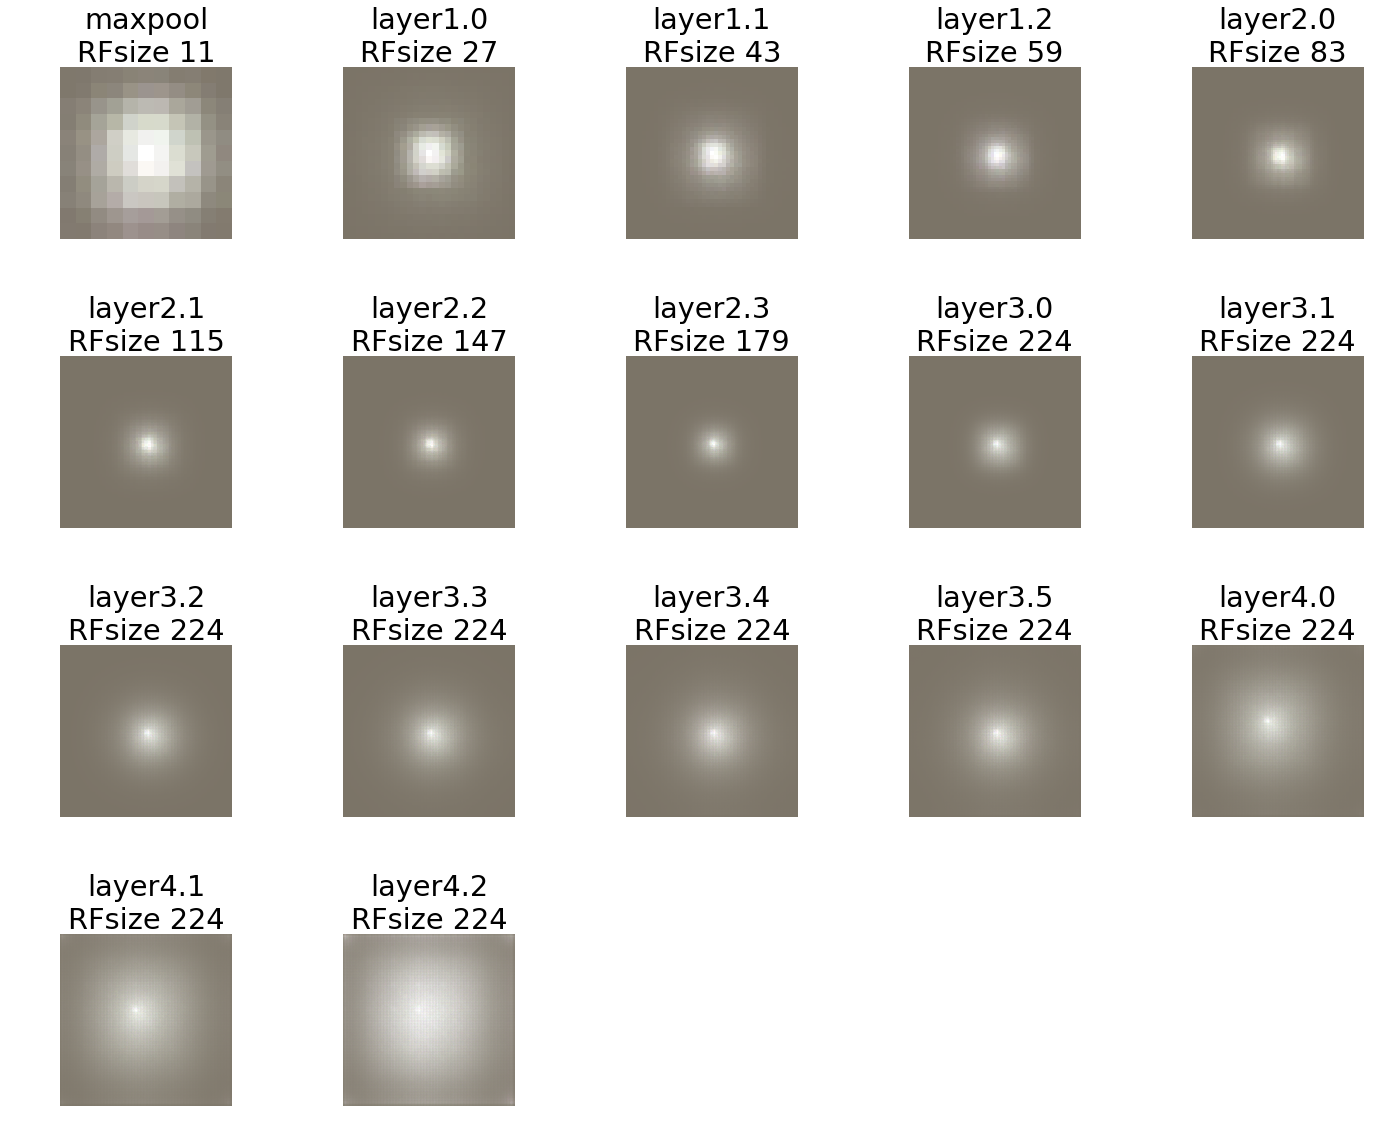

100%|██████████| 512/512 [03:54<00:00,  2.20it/s]


maxpool 107 118 107 118
layer1.0 99 126 99 126
layer1.1 91 134 91 134
layer1.2 83 142 83 142
layer2.0 71 154 71 154
layer2.1 55 170 55 170
layer2.2 39 186 39 186
layer2.3 23 202 23 202
layer3.0 0 224 0 224
layer3.1 0 224 0 224
layer3.2 0 224 0 224
layer3.3 0 224 0 224
layer3.4 0 224 0 224
layer3.5 0 224 0 224
layer4.0 0 224 0 224
layer4.1 0 224 0 224
layer4.2 0 224 0 224


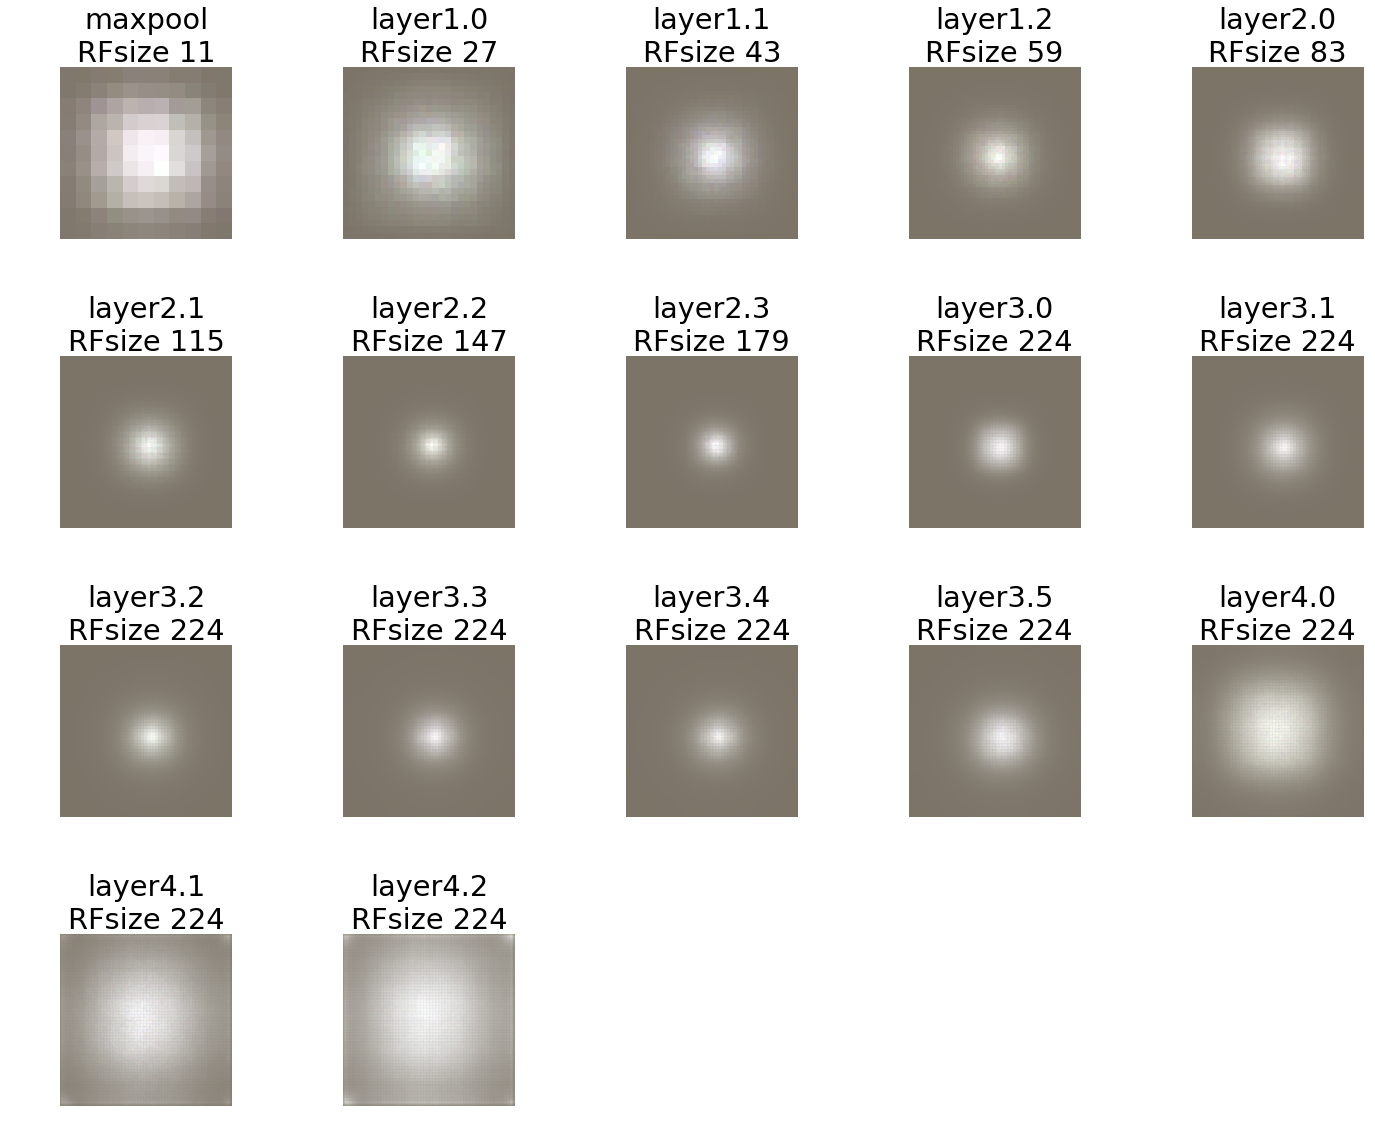

In [69]:
exts = ("png", "pdf")

plt.rcParams["font.size"] = 24

erfs_arch = {}
for arch in archs:

    model = get_model(arch)
    model = model.eval()
    model = model.to(device)

    tracker = TensorTrackerInputGrad(model, ignore_BN=True, detach_tensors=True)

    _ = model(images)

    out_dir = "20210118/{}".format(arch)
    make_dir(out_dir)
    g_imgs_layers = []
    M = 10
    for cnt, layer_name in enumerate(analyis_layers):
        torch.manual_seed(815)
        channel = channels[layer_name]
        g_imgs = []
        for j in tqdm(range(channel)):
            tmp_images = torch.randn(M, 3, 224, 224).to(device)
            tmp_images = tmp_images.requires_grad_()

            model.zero_grad()

            out = model.layer_forward(tmp_images, layers=[layer_name])[layer_name]

            g_y = torch.zeros(*out.shape)
            g_y[:, j, out.shape[-2] // 2, out.shape[-1] // 2] = 1
        #     g_y = torch.ones(out[:, j, 7 // 2, 7 // 2].shape)
            g_y = g_y.to(device)
        #     out[:, j, 7 // 2, 7 // 2].backward(gradient=g_y)
            out.backward(gradient=g_y)
            g_img = tracker.grad_pool_in["conv1"].detach().numpy()
            g_imgs.append(g_img)

        g_imgs = np.concatenate(g_imgs, axis=0)
        g_imgs_layers.append(g_imgs)

    tracker.remove_hook()



    erfs = []
    for cnt, layer_name in enumerate(analyis_layers):
        center_pos = 224 / 2
        rf_size = rf_sizes[layer_name]
        rf_size = 224 if rf_size > 224 else rf_size
        x1 = int(np.ceil(center_pos - rf_size / 2))
        x2 = int(np.ceil(center_pos + rf_size / 2))
        y1 = int(np.ceil(center_pos - rf_size / 2))
        y2 = int(np.ceil(center_pos + rf_size / 2))
        print(layer_name, x1, x2, y1, y2)
        erf = np.abs(g_imgs_layers[cnt][:, :, x1:x2, y1:y2]).mean(0)
        erfs.append(erf)
    erfs_arch[arch] = erfs

    def _normalize(_x):
        _x = plots.normalize_inputspace(_x, img_format="HWC")
        _x = plots.input2image(_x, img_format="HWC")
        return _x

    def _title(i, img):
        layer_name = analyis_layers[i]
        rfsize = rf_sizes[layer_name]
        rfsize = 224 if rfsize > 224 else rfsize
        msg = "{}\nRFsize {}".format(layer_name, rfsize)
        return msg


    out_name = "{}-erfs".format(arch, )
    plots.plot_imshows(erfs, show_flag=True, normalize=_normalize, title=_title, scale=4, out_dir=out_dir, exts=exts, out_name=out_name)

In [72]:
keys = list(erfs_arch.keys())

In [89]:
rf_sizes

{'maxpool': 11,
 'layer1.0': 27,
 'layer1.1': 43,
 'layer1.2': 59,
 'layer2.0': 83,
 'layer2.1': 115,
 'layer2.2': 147,
 'layer2.3': 179,
 'layer3.0': 227,
 'layer3.1': 291,
 'layer3.2': 355,
 'layer3.3': 419,
 'layer3.4': 483,
 'layer3.5': 547,
 'layer4.0': 643,
 'layer4.1': 771,
 'layer4.2': 899}

In [90]:
224 * 2 // 11

40

In [97]:
def _normalize(_x):
    _x = plots.normalize_inputspace(_x)
    _x = plots.input2image(_x)
    return _x

data = []
for cnt, layer_name in enumerate(analyis_layers):
    img = []
    for key in keys:
        _img = erfs_arch[key][cnt]
        _img = _normalize(_img)
        img.append(_img)
    img = np.asarray(img)
    rf_size = rf_sizes[layer_name]
    rf_size = 224 if rf_size > 224 else rf_size
    padding = rf_size * 1 // 11
    print(padding)
    data.append(plots.make_grid(img, nrow=2, pad_value=0, padding=padding))

1
2
3
5
7
10
13
16
20
20
20
20
20
20
20
20
20


In [95]:
keys

['resnet34-skip4', 'resnet34-plain4']

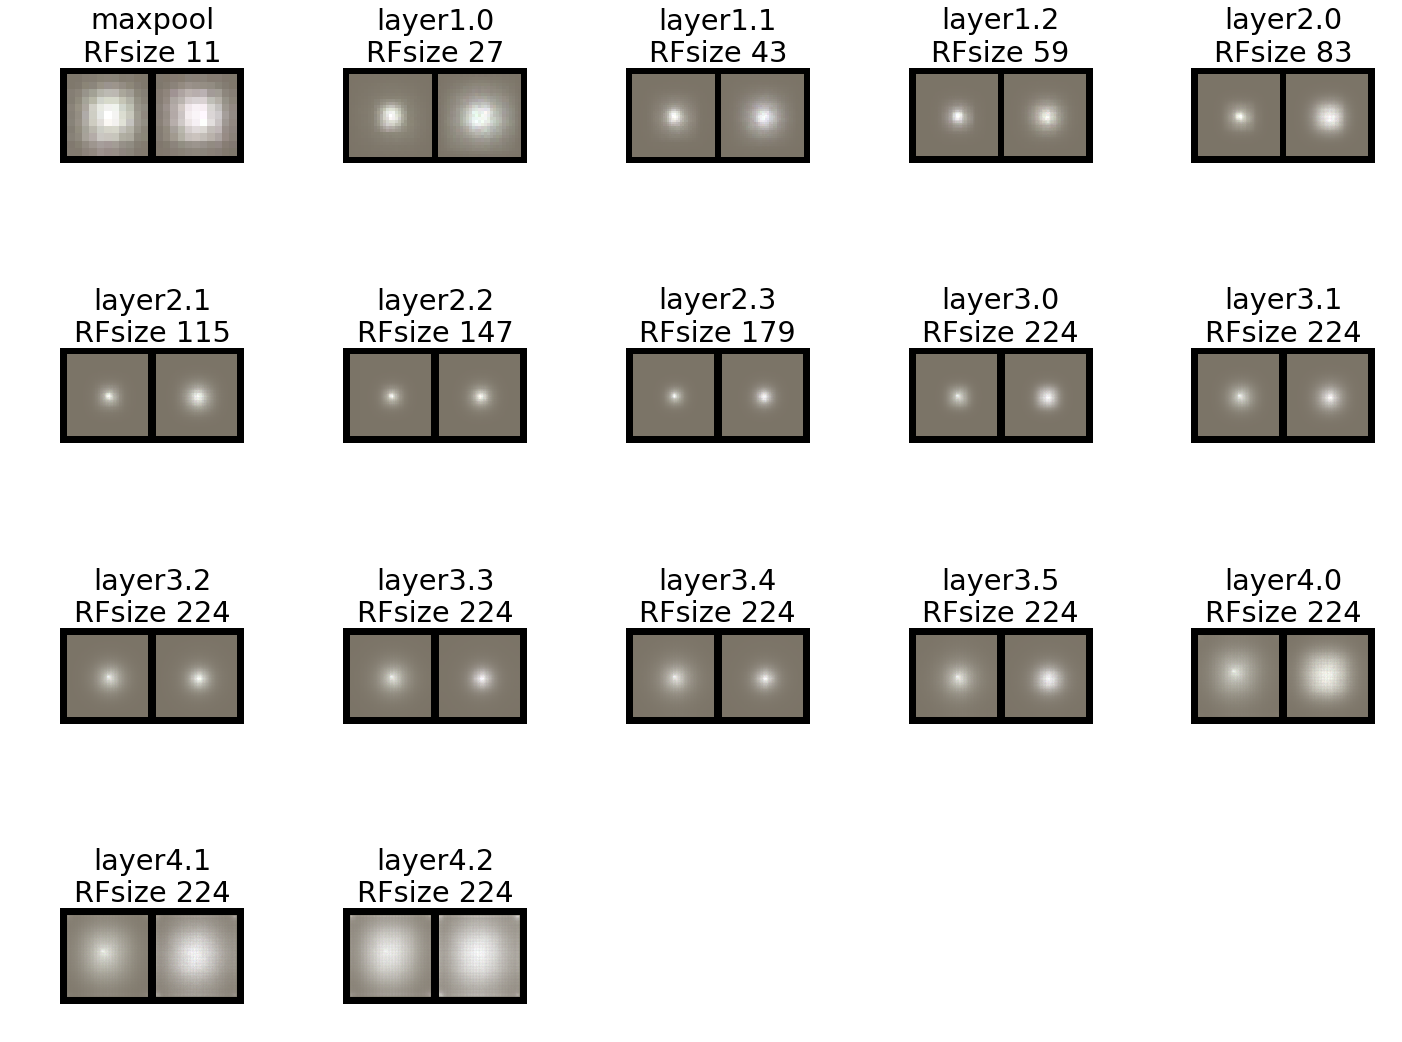

In [96]:
out_dir = "20210118"
out_name = "erfs".format()
plots.plot_imshows(data, show_flag=True, normalize=None, title=_title, scale=4, out_dir=out_dir, exts=exts, out_name=out_name)

In [98]:
key

'resnet34-plain4'

In [99]:
erfs_arch.keys()

dict_keys(['resnet34-skip4', 'resnet34-plain4'])

In [103]:
def _normalize(_x):
    _x = plots.normalize_inputspace(_x)
    _x = plots.input2image(_x)
    return _x

figsize = (7, 7)
for key in erfs_arch.keys():
    out_dir = "20210118/{}".format(key)
    for cnt, layer_name in enumerate(analyis_layers):        
        out_name = "erfs-{}-{}".format(key, layer_name)
        _img = erfs_arch[key][cnt].copy()
        _img = _normalize(_img)
        plt.figure(figsize=figsize)
        plots.imshow_helper(_img)
        plt.axis("off")
        for ext in exts:
            path = os.path.join(out_dir, out_name + "." + ext)
            plt.savefig(path, transparent=True)
        plt.close()

In [101]:
_img.shape

(3, 224, 224)

In [102]:
_img.max(), _img.min()

(0.003079422, 0.00022715365)

In [148]:

def lineprofile(data):
    assert data.ndim == 2
    
    h, w = data.shape
    c_w = w // 2
    c_h = h // 2
    tmp_data = data[c_h, :]
    return tmp_data

def _ms(tmp_data):
    assert tmp_data.ndim == 1
    
    tmp_data = tmp_data / tmp_data.sum()    
    w = tmp_data.shape[0]
    c_w = w // 2
#     x = np.linspace(-c_w, c_w, w)
    if w % 2 == 1:
        x = np.arange(-c_w, c_w + 1)
    else:
        x = np.arange(-c_w, c_w)
    x = x / w
    m1 = np.sum(x * tmp_data)
    m2 = np.sum(np.power(x - m1, 2) * tmp_data)
    m3 = np.sum(np.power(x - m1, 3) * tmp_data)
    m4 = np.sum(np.power(x - m1, 4) * tmp_data)
    return m1, m2, m3, m4

resnet34-plain4


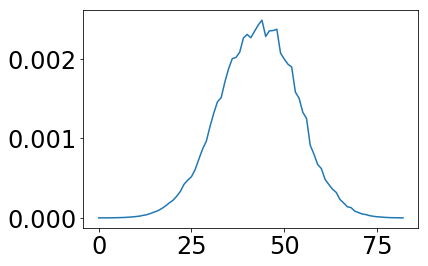

In [149]:
print(key)
_img = erfs_arch[key][4].copy()
tmp_data = lineprofile(_img.mean(0))
plt.figure()
plt.plot(tmp_data)
plt.show()
ms = _ms(tmp_data)

In [150]:
ms

(0.02291632823721283,
 0.015452494438310026,
 -0.0001384098219494152,
 0.0007034269950963195)

In [151]:
ms[3] / ms[1]

0.045521905728849454

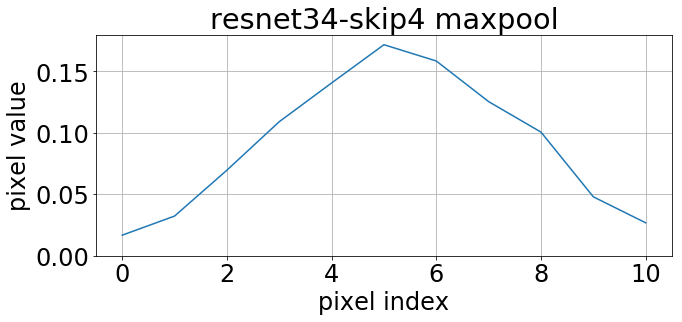

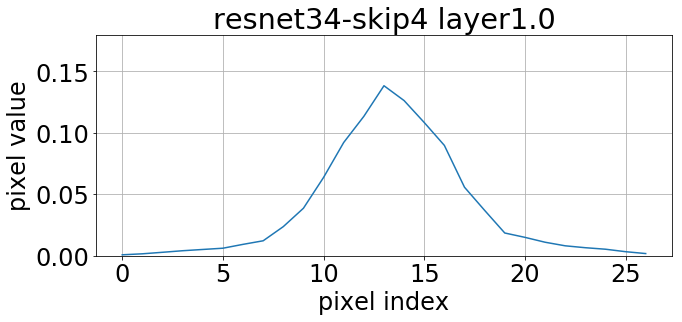

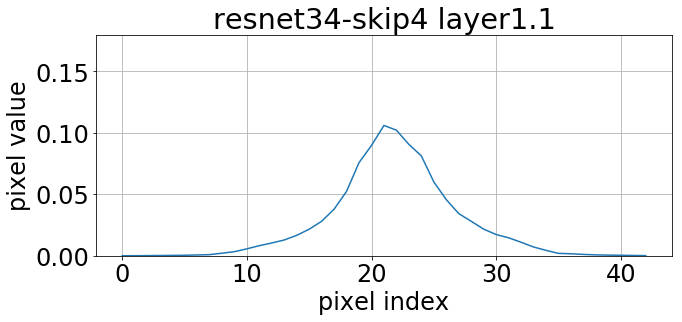

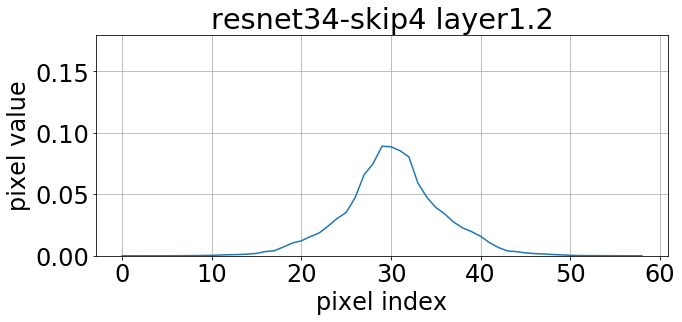

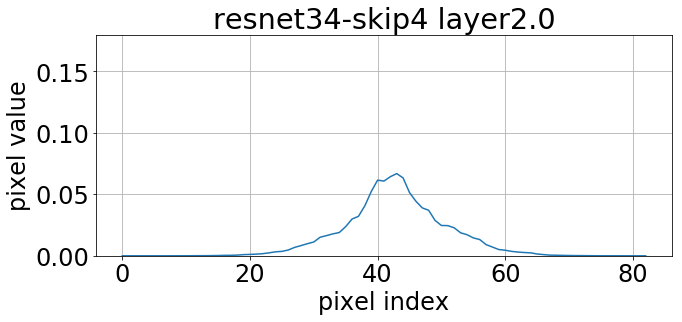

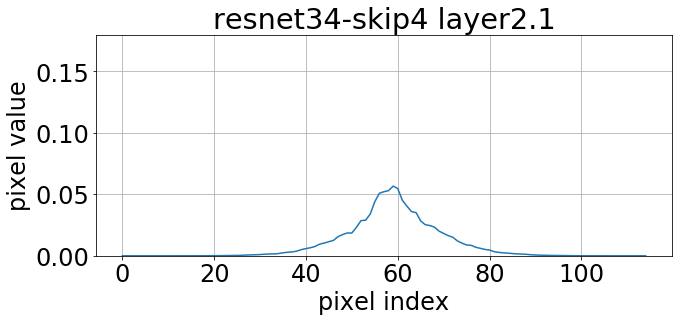

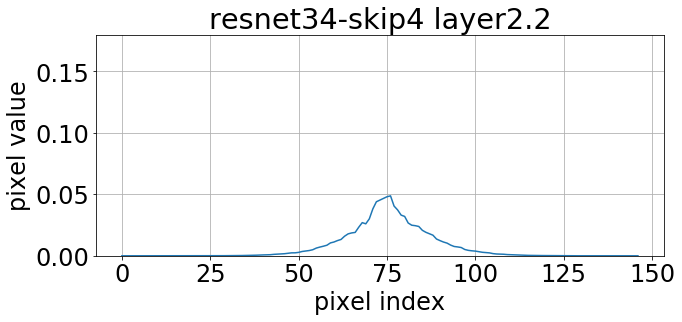

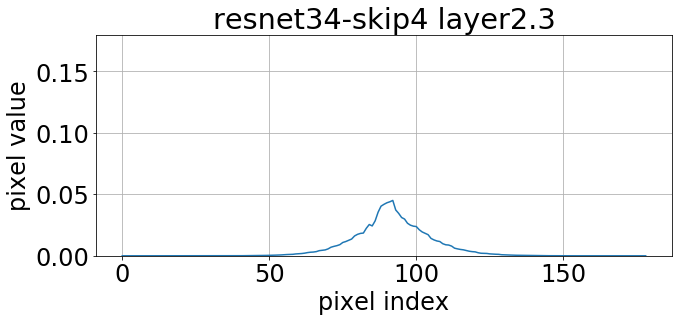

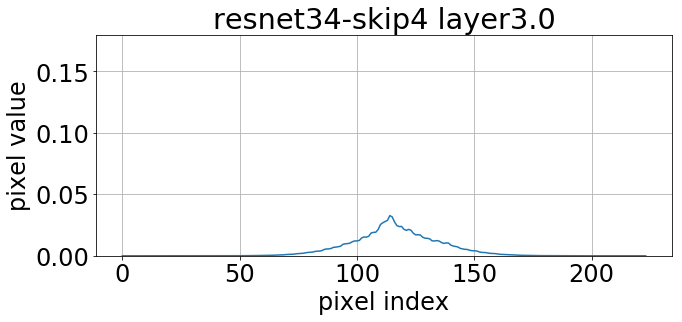

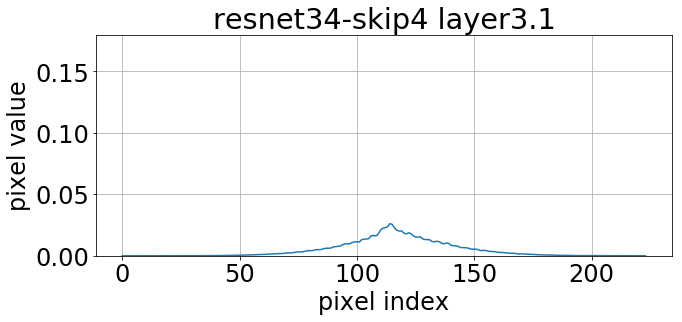

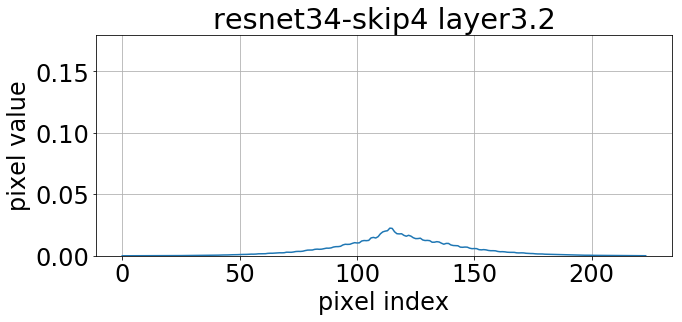

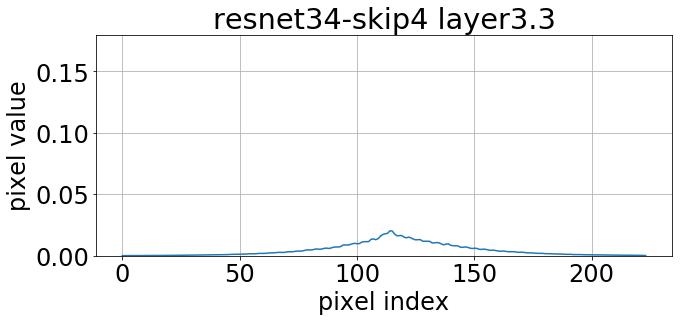

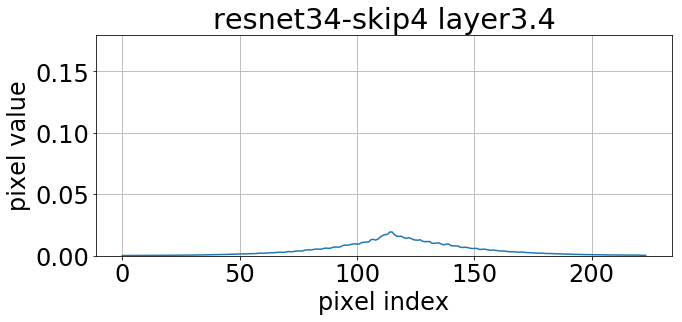

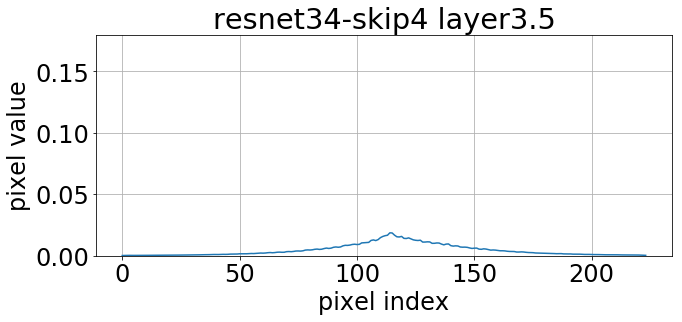

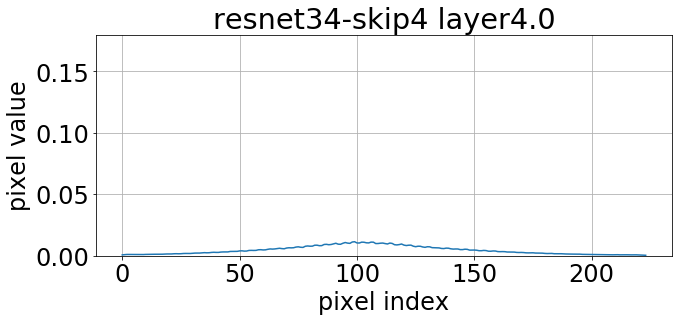

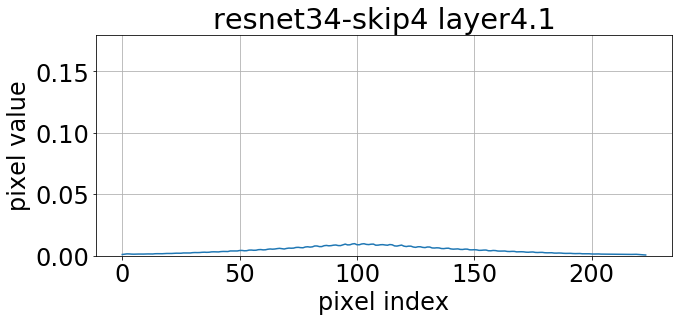

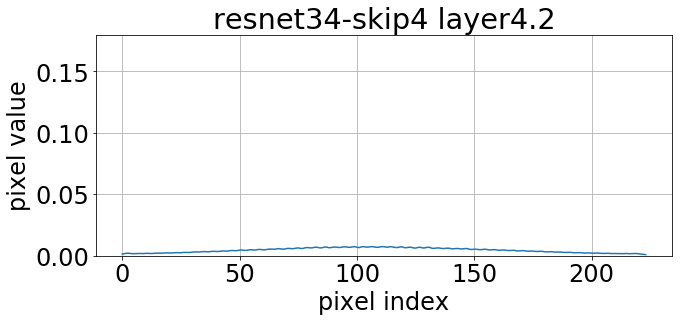

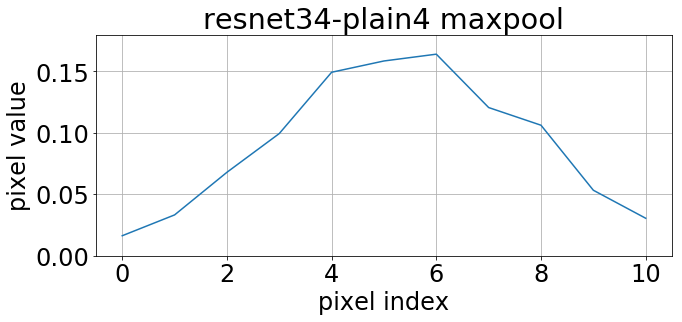

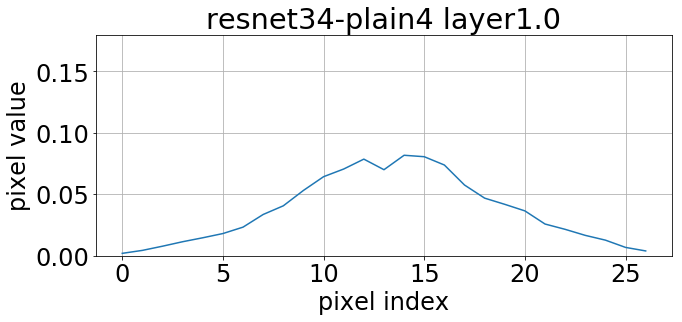

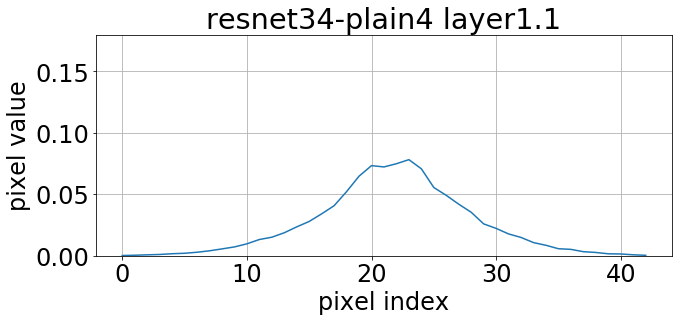

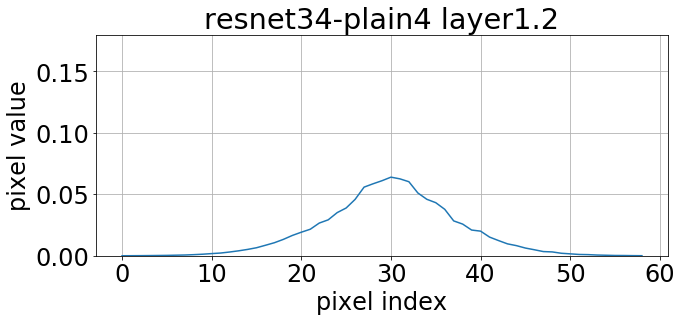

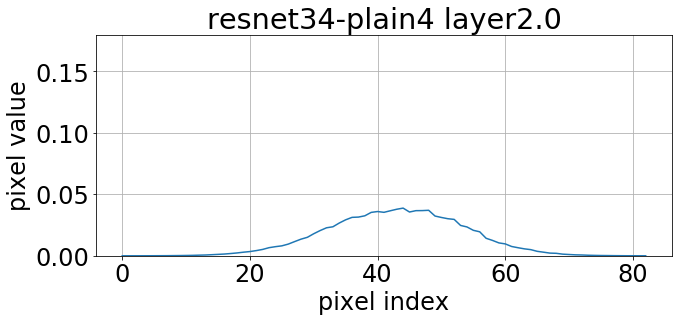

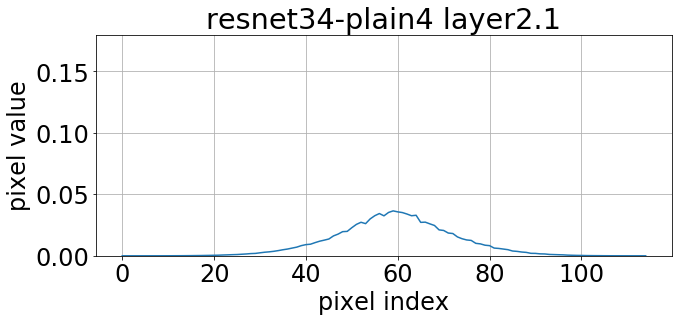

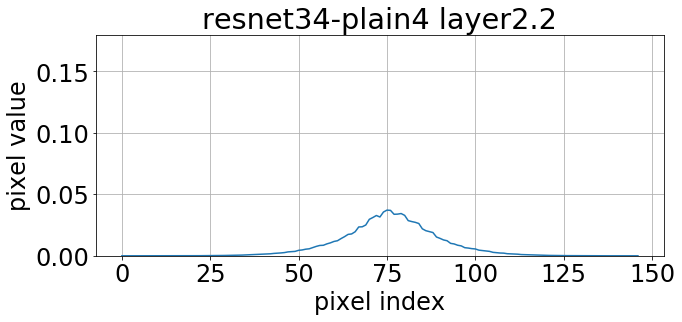

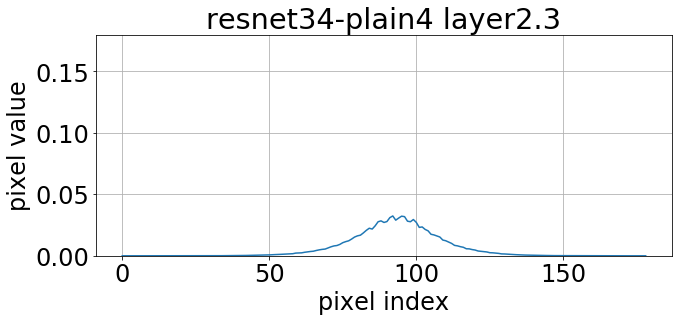

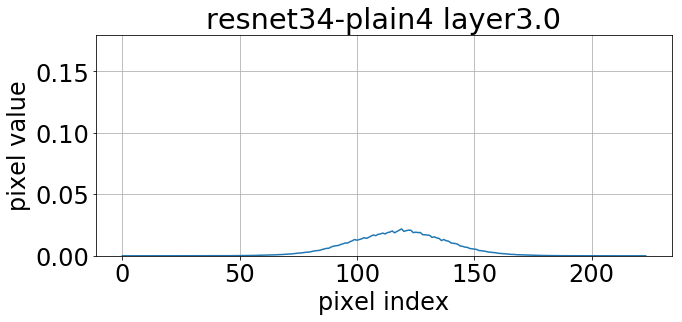

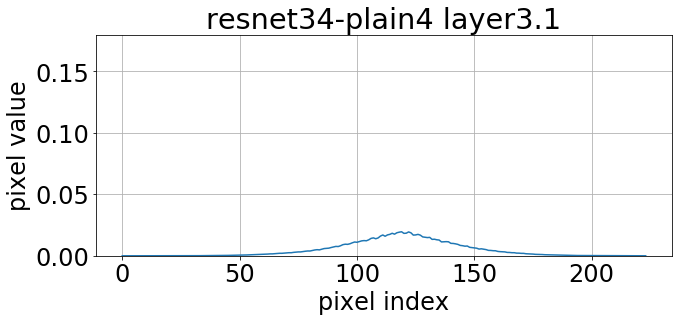

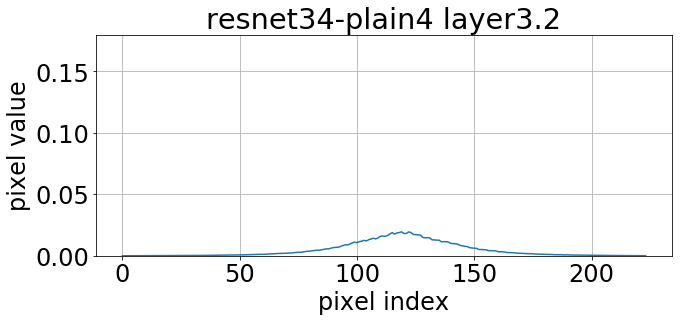

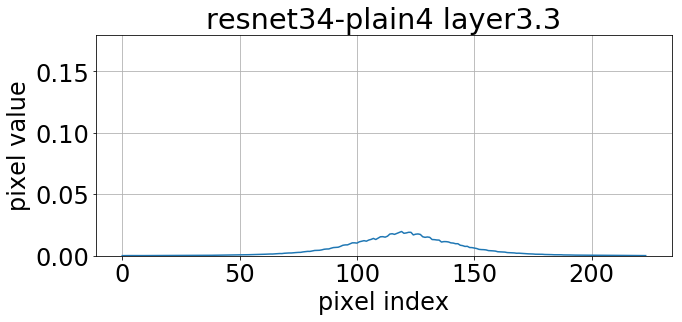

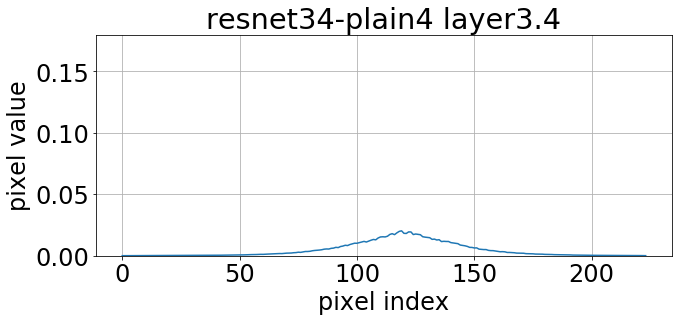

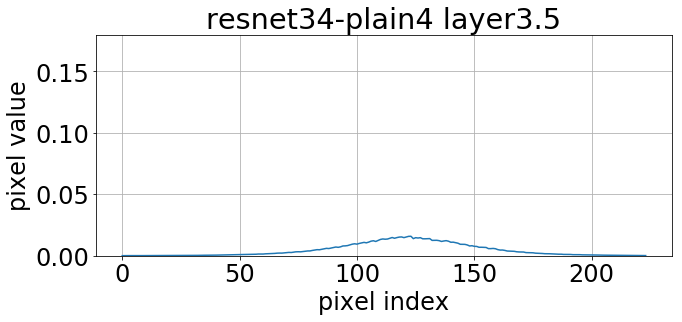

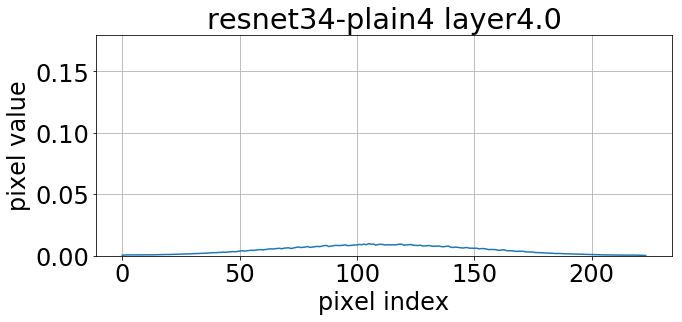

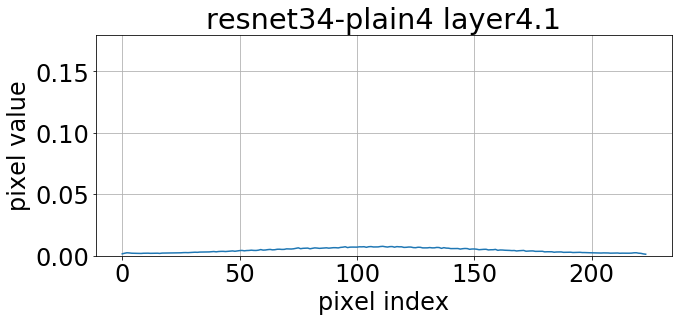

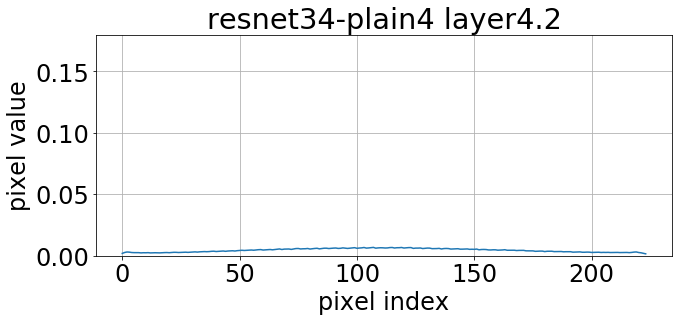

In [184]:
figsize = (10, 5)

ms_arch = {}
for key in erfs_arch.keys():
    out_dir = "20210118/{}".format(key)
    ms_arch[key] = []
    for cnt, layer_name in enumerate(analyis_layers):        
        out_name = "lineprofile-{}-{}".format(key, layer_name)
        _img = erfs_arch[key][cnt].copy()
        tmp_data = lineprofile(_img.mean(0))
        tmp_data = tmp_data / tmp_data.sum()
        title = "{} {}".format(key, layer_name)
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.plot(tmp_data)
        plt.ylim(0, 0.18)
        plt.xlabel("pixel index")
        plt.ylabel("pixel value")
        plt.grid()
        plt.tight_layout()
        for ext in exts:
            path = os.path.join(out_dir, out_name + ".{}".format(ext))
            plt.savefig(path, transparent=True)
        plt.show()
        ms = _ms(tmp_data)
        ms_arch[key].append(ms)
    ms_arch[key] = np.asarray(ms_arch[key])

In [155]:
ms_arch[key][:, 0]

array([ 0.02939884,  0.01951448,  0.01912529,  0.0158826 ,  0.02291633,
        0.02044509,  0.02012317,  0.02360224,  0.02623832,  0.03035705,
        0.03291528,  0.03219893,  0.03477108,  0.04275215, -0.0121397 ,
       -0.00425185, -0.00323419])

In [168]:
kurtosis = {}
for key in ms_arch:
    kurtosis[key] = ms_arch[key][:, 3] / ms_arch[key][:, 1]

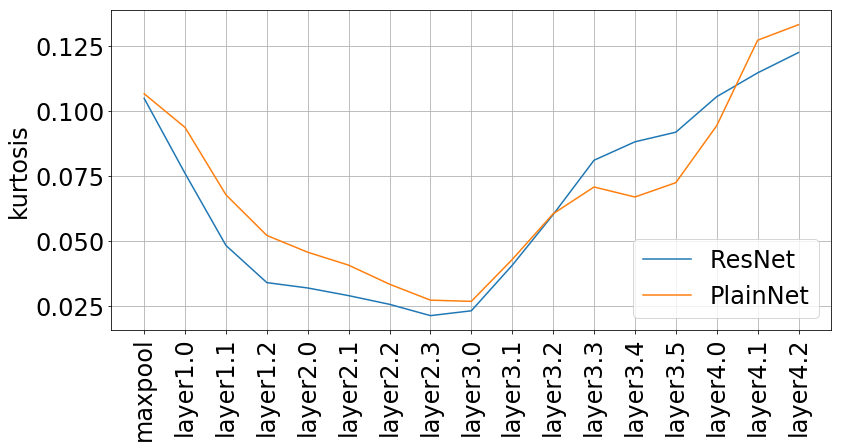

In [193]:
figsize = (16 * 0.75, 9 * 0.75 )
def _label(key):
    if "skip" in key:
        return "ResNet"
    elif "plain" in key:
        return "PlainNet"
    else:
        raise ValueError("error")
plt.figure(figsize=figsize)
for key in kurtosis:
    label = _label(key)
    plt.plot(kurtosis[key], label=label)
plt.legend()
# plt.yscale("log")
plt.ylabel("kurtosis")
plt.xticks(ticks=range(len(analyis_layers)), labels=analyis_layers, rotation=90)
plt.grid()
plt.tight_layout()
out_dir = "20210118/"
out_name = "kurtosis"
for ext in exts:
    path = os.path.join(out_dir, out_name + ".{}".format(ext))
    plt.savefig(path, transparent=True)
plt.show()

In [191]:
variance = {}
for key in ms_arch:
    variance[key] = ms_arch[key][:, 1]

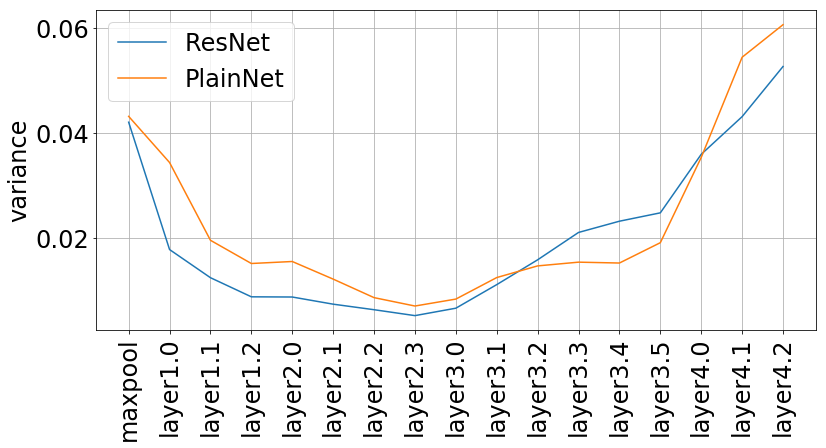

In [194]:
figsize = (16 * 0.75, 9 * 0.75 )
def _label(key):
    if "skip" in key:
        return "ResNet"
    elif "plain" in key:
        return "PlainNet"
    else:
        raise ValueError("error")
plt.figure(figsize=figsize)
for key in kurtosis:
    label = _label(key)
    plt.plot(variance[key], label=label)
plt.legend()
# plt.yscale("log")
plt.ylabel("variance")
plt.xticks(ticks=range(len(analyis_layers)), labels=analyis_layers, rotation=90)
plt.grid()
plt.tight_layout()
out_dir = "20210118/"
out_name = "variance"
for ext in exts:
    path = os.path.join(out_dir, out_name + ".{}".format(ext))
    plt.savefig(path, transparent=True)
plt.show()

In [132]:
tmp_data.sum()

0.3734436

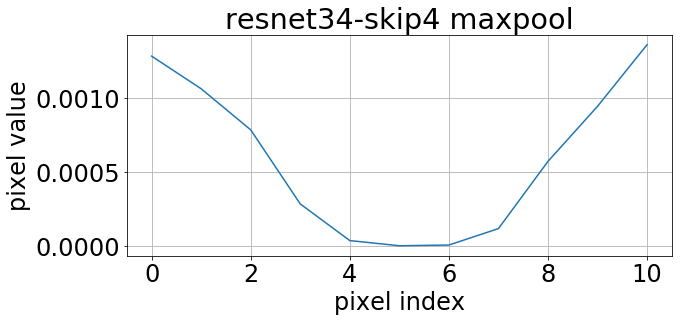

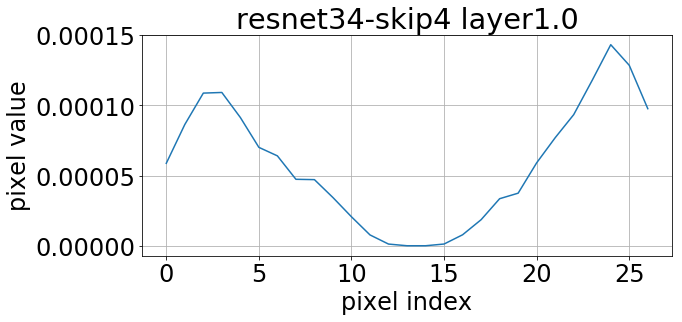

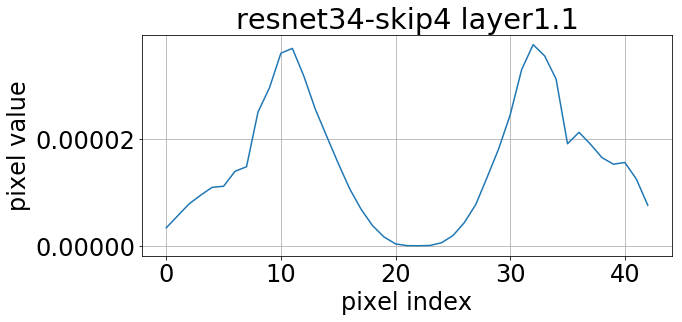

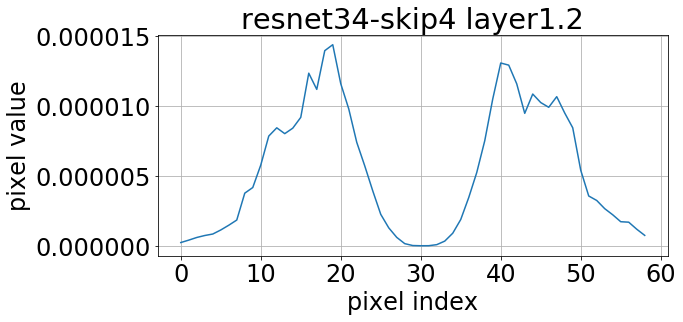

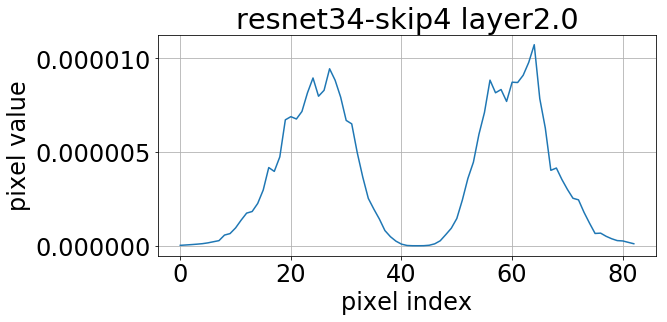

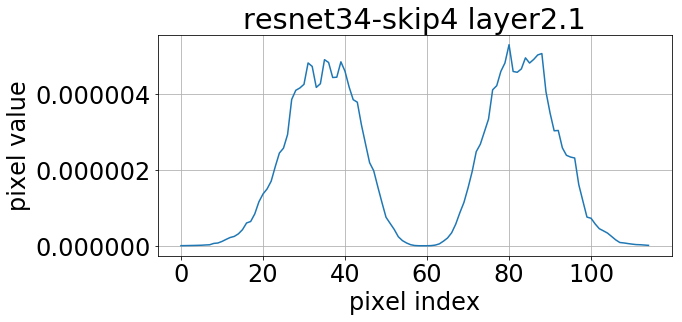

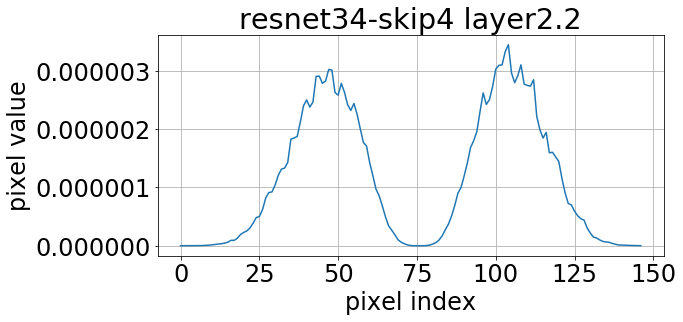

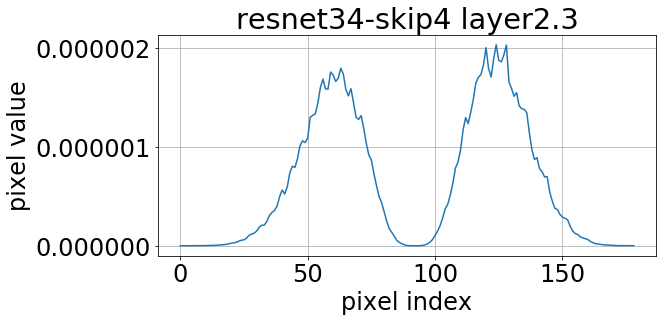

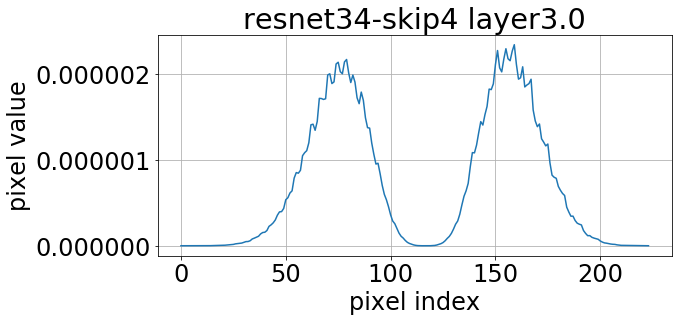

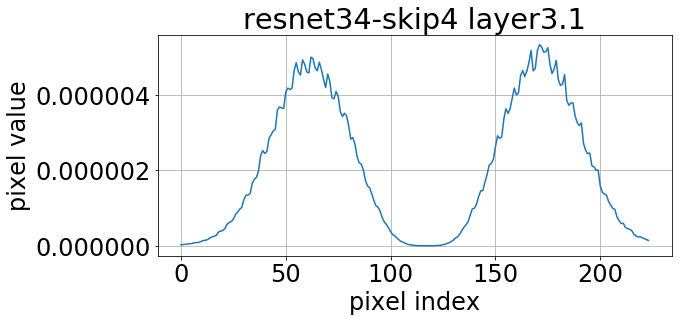

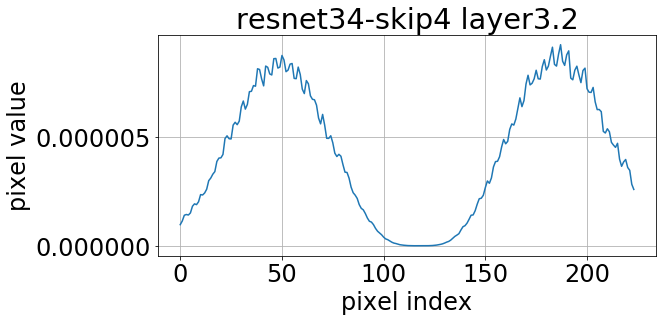

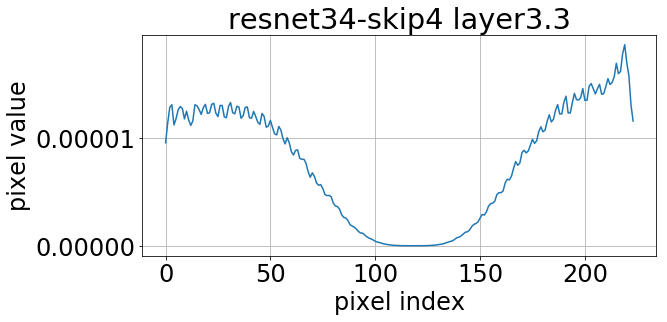

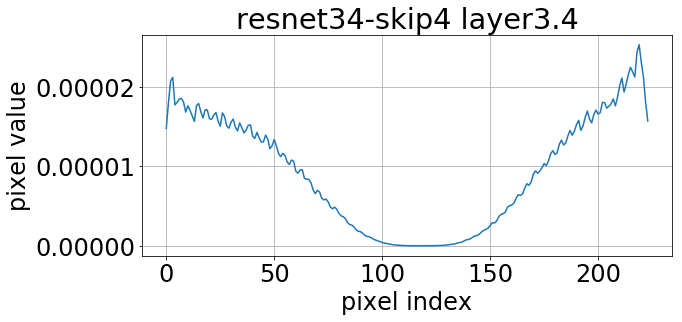

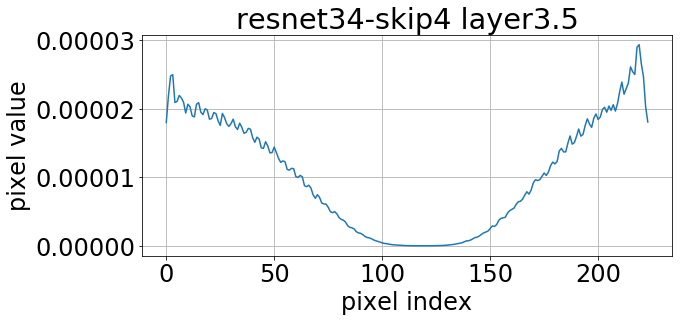

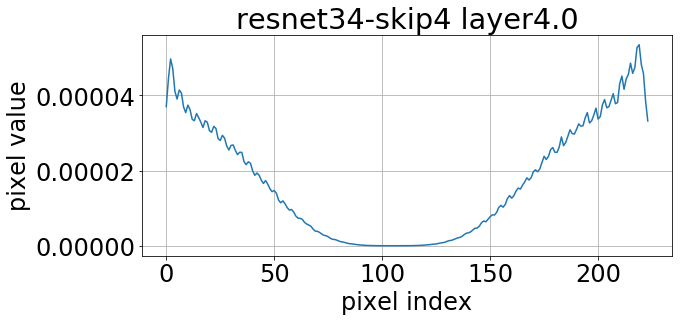

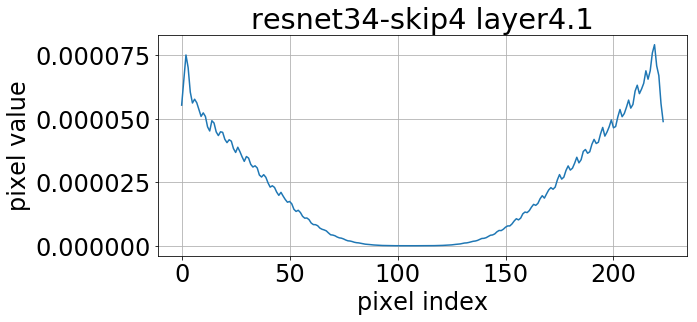

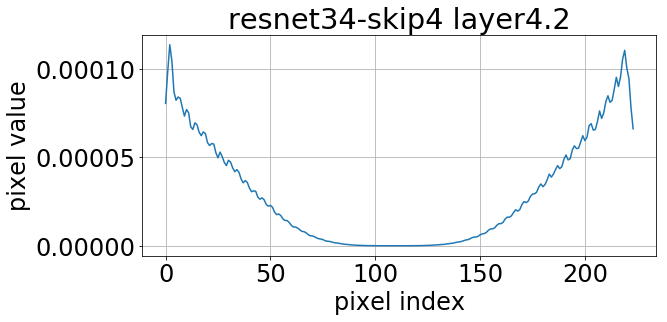

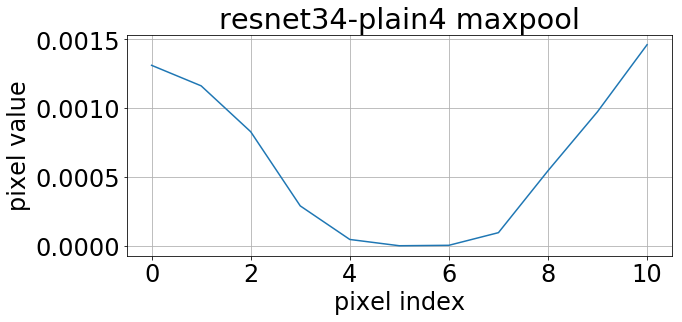

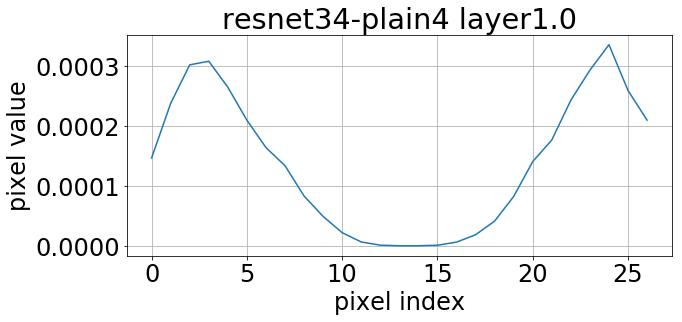

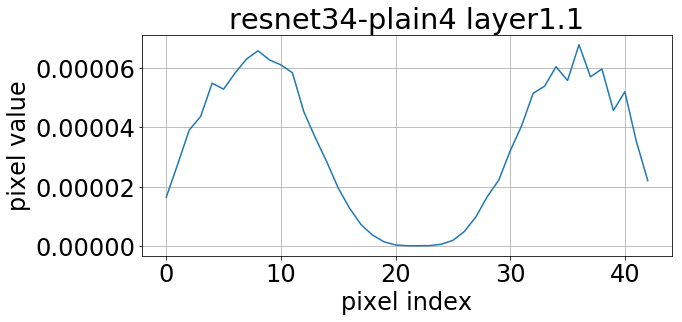

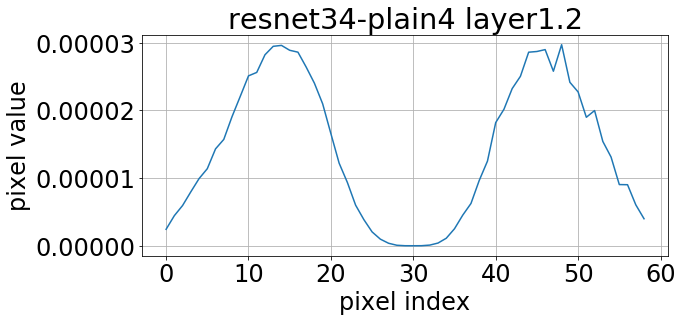

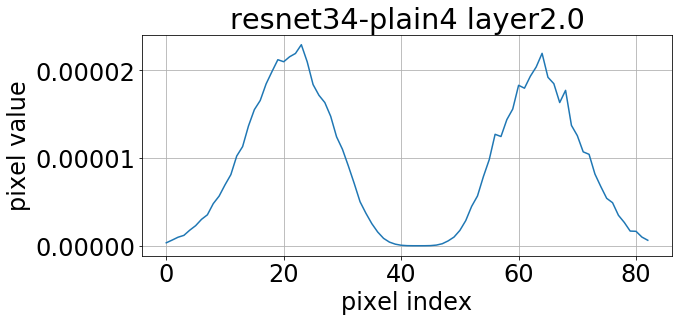

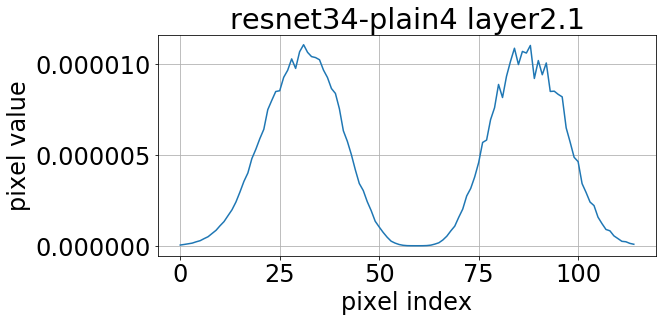

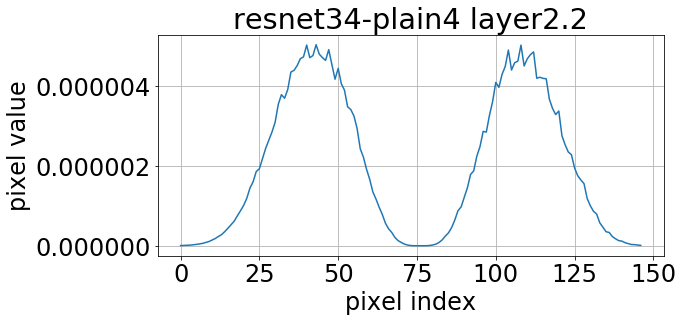

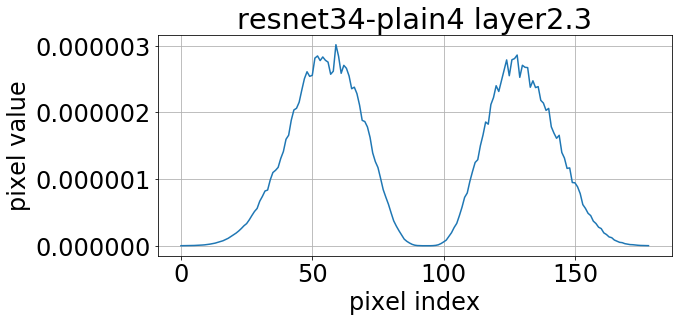

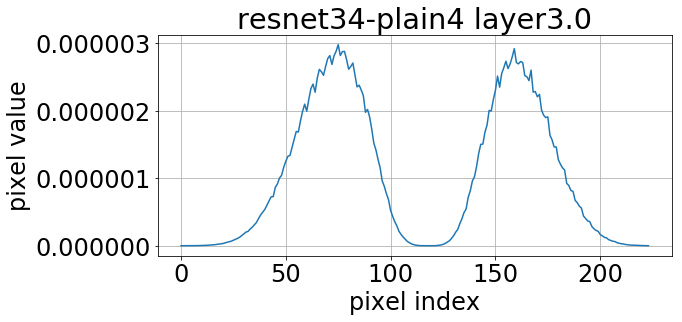

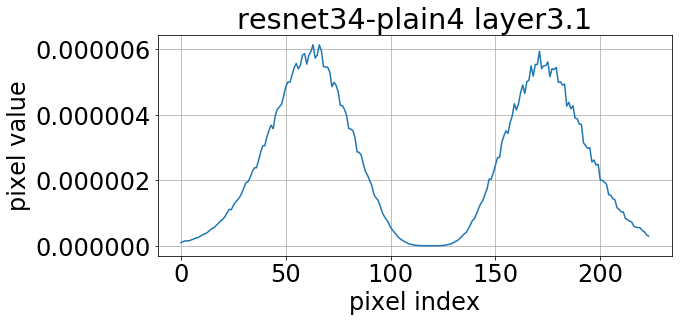

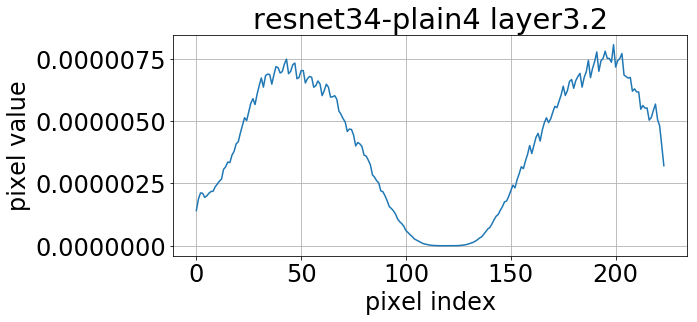

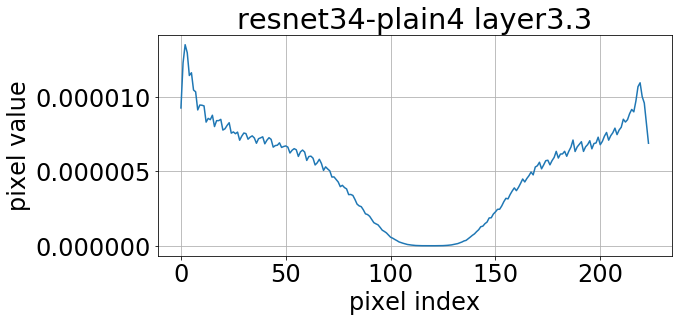

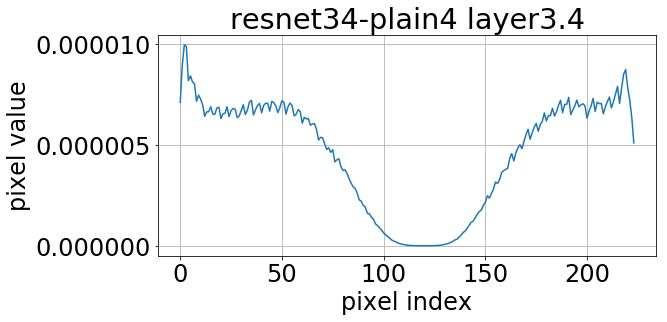

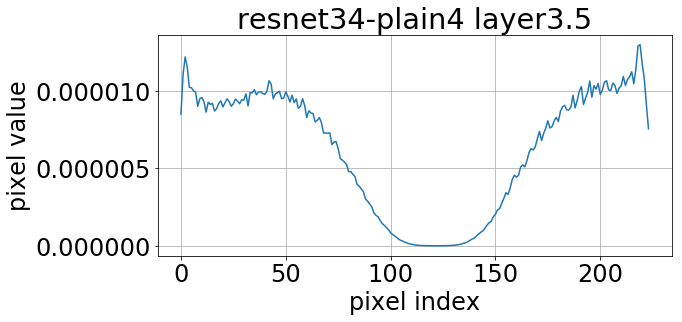

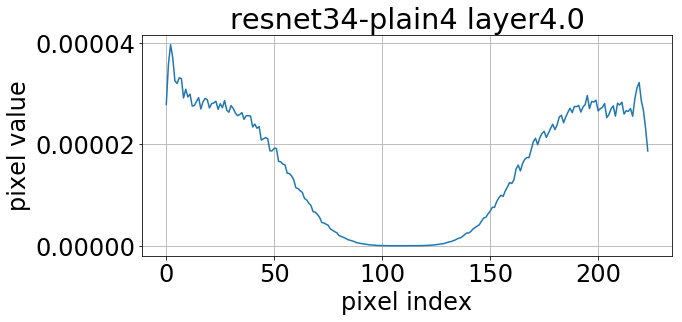

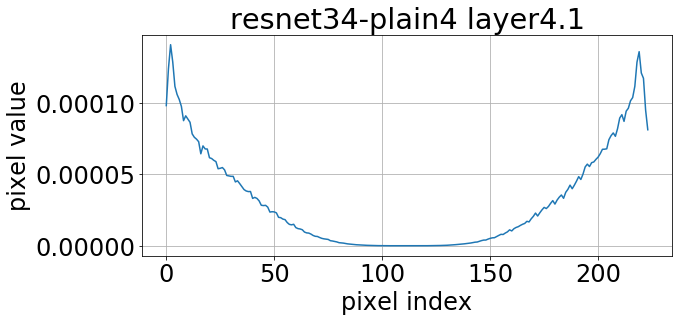

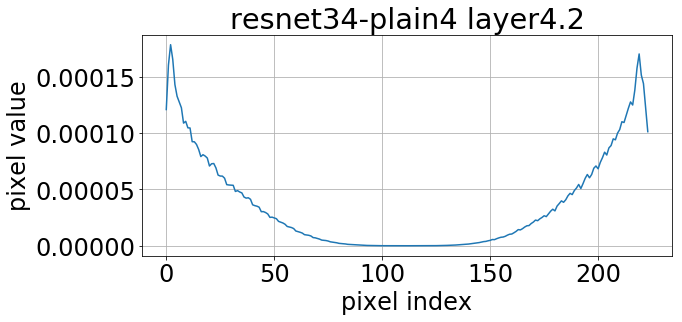

In [190]:
figsize = (10, 5)

ms_arch = {}
for key in erfs_arch.keys():
    out_dir = "20210118/{}".format(key)
    ms_arch[key] = []
    for cnt, layer_name in enumerate(analyis_layers):        
        out_name = "lineprofile-{}-{}".format(key, layer_name)
        _img = erfs_arch[key][cnt].copy()
        tmp_data = lineprofile(_img.mean(0))
        tmp_data = tmp_data / tmp_data.sum()
        title = "{} {}".format(key, layer_name)
        plt.figure(figsize=figsize)
        plt.title(title)
        w = tmp_data.shape[0]
        x = np.linspace(-0.5, 0.5, w)
        m1 = np.sum(x * tmp_data)
        plt.plot(tmp_data * (x - m1) ** 4)
#         plt.ylim(0, 0.18)
        plt.xlabel("pixel index")
        plt.ylabel("pixel value")
        plt.grid()
        plt.tight_layout()
#         for ext in exts:
#             path = os.path.join(out_dir, out_name + ".{}".format(ext))
#             plt.savefig(path, transparent=True)
        plt.show()
        ms = _ms(tmp_data)
        ms_arch[key].append(ms)
    ms_arch[key] = np.asarray(ms_arch[key])